In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

from audiolabel import df2tg
from phonlab.utils import dir2df, get_timestamp_now

import ceti

In [5]:
calfcsv = Path('Combined ESC-Calf Codas marked.csv')
wavdir = Path('/global/scratch/users/rsprouse/datasets/ceti/DSWP')
eventtype = 'calf'
resample_rate = 48000
click_offset = -0.002
click_window = 0.015
click_window_str = '{}'.format(click_window).lstrip('0')
ltas_bw = 100 # Praat 'To Ltas...' bandwidth param
praat_spec_fast = False  # Praat 'To Spectrum...' fast param
dropIPI = True # If True, drop IPI# columns from google codas spreadsheet

In [6]:
def load_calf(csvfile, dropIPI):
    '''
    Load codas found in `Combined ESC-Calf Codas marked.csv` as a dataframe.
    '''
    colmap = pd.DataFrame.from_dict({
        '': '',
        'File_name': 'wavfile',
        'Start.time': 'coda_t1',
        'ICI 1': 'ICI1',
        'ICI 2': 'ICI2',
        'ICI 3': 'ICI3',
        'ICI 4': 'ICI4',
        'ICI 5': 'ICI5',
        'ICI 6': 'ICI6',
        'ICI 7': 'ICI7',
        'IPI 1': 'IPI1',
        'IPI 2': 'IPI2',
        'IPI 3': 'IPI3',
        'IPI 4': 'IPI4',
        'IPI 5': 'IPI5',
        'IPI 6': 'IPI6',
        'IPI 7': 'IPI7',
        'IPI 8': 'IPI8',
        'CodaSorterOutput': ''
    }, orient='index', columns=['newcol']).reset_index(names=['oldcol'])
    colcond = colmap['newcol'] != ''
    if dropIPI is True:
        colcond &= ~colmap['newcol'].str.startswith('IPI')
    codas = pd.read_csv(
        csvfile,
        names=colmap[colcond]['newcol'],
        usecols=colmap[colcond].index,
        header=0,
        dtype={}
    ).reset_index(names='fauxda')
    icicols = [c for c in codas.columns if c.startswith('ICI')]
    codas['nClicks'] = (codas[icicols] != 0).values.sum(axis=-1) + 1

    return codas

codas = load_calf(calfcsv, dropIPI=True)
clicks = ceti.codadf2clickdf(codas, 'fauxda', 'coda_t1')
clicks

,fauxda,clicknum,wavfile,coda_t1,nClicks,ICI,t1
0,0,1,2011MAR07-016,3.7067,5,0.087686,3.706700
1,0,2,2011MAR07-016,3.7067,5,0.074008,3.794386
2,0,3,2011MAR07-016,3.7067,5,0.074612,3.868394
3,0,4,2011MAR07-016,3.7067,5,0.078517,3.943006
4,0,5,2011MAR07-016,3.7067,5,0.000000,4.021523
...,...,...,...,...,...,...,...
1561,308,1,MAY5-008,340.5645,5,0.426876,340.564500
1562,308,2,MAY5-008,340.5645,5,0.390375,340.991376
1563,308,3,MAY5-008,340.5645,5,0.224028,341.381751
1564,308,4,MAY5-008,340.5645,5,0.179904,341.605780


In [7]:
# Merge with available audio files. Clicks that don't have a matching audio file
# are dropped.
clicks = clicks.merge(
    dir2df(wavdir, fnpat='\.wav$', addcols=['barename', 'ext']),
    how='inner',
    left_on='wavfile',
    right_on='barename'
)
clicks['audidx'] = np.arange(len(clicks), dtype=int)
clicks['extract_t1'] = clicks['t1'] + click_offset
clicks['extract_t2'] = clicks['extract_t1'] + click_window
clicks

,fauxda,clicknum,wavfile,coda_t1,nClicks,ICI,t1,relpath,fname,barename,ext,audidx,extract_t1,extract_t2
0,0,1,2011MAR07-016,3.7067,5,0.087686,3.706700,2022-10-18 19.33.04 - 2011 Shane Gero,2011MAR07-016.wav,2011MAR07-016,.wav,0,3.704700,3.719700
1,0,2,2011MAR07-016,3.7067,5,0.074008,3.794386,2022-10-18 19.33.04 - 2011 Shane Gero,2011MAR07-016.wav,2011MAR07-016,.wav,1,3.792386,3.807386
2,0,3,2011MAR07-016,3.7067,5,0.074612,3.868394,2022-10-18 19.33.04 - 2011 Shane Gero,2011MAR07-016.wav,2011MAR07-016,.wav,2,3.866394,3.881394
3,0,4,2011MAR07-016,3.7067,5,0.078517,3.943006,2022-10-18 19.33.04 - 2011 Shane Gero,2011MAR07-016.wav,2011MAR07-016,.wav,3,3.941006,3.956006
4,0,5,2011MAR07-016,3.7067,5,0.000000,4.021523,2022-10-18 19.33.04 - 2011 Shane Gero,2011MAR07-016.wav,2011MAR07-016,.wav,4,4.019523,4.034523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,308,1,MAY5-008,340.5645,5,0.426876,340.564500,2008,MAY5-008.wav,MAY5-008,.wav,671,340.562500,340.577500
672,308,2,MAY5-008,340.5645,5,0.390375,340.991376,2008,MAY5-008.wav,MAY5-008,.wav,672,340.989376,341.004376
673,308,3,MAY5-008,340.5645,5,0.224028,341.381751,2008,MAY5-008.wav,MAY5-008,.wav,673,341.379751,341.394751
674,308,4,MAY5-008,340.5645,5,0.179904,341.605780,2008,MAY5-008.wav,MAY5-008,.wav,674,341.603780,341.618780


In [8]:
clicks[clicks['barename'] == '2011Mar15-002']

,fauxda,clicknum,wavfile,coda_t1,nClicks,ICI,t1,relpath,fname,barename,ext,audidx,extract_t1,extract_t2
10,2,1,2011Mar15-002,207.5833,5,0.242390,207.583300,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,10,207.581300,207.596300
11,2,2,2011Mar15-002,207.5833,5,0.276100,207.825690,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,11,207.823690,207.838690
12,2,3,2011Mar15-002,207.5833,5,0.190765,208.101790,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,12,208.099790,208.114790
13,2,4,2011Mar15-002,207.5833,5,0.127377,208.292556,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,13,208.290556,208.305556
14,2,5,2011Mar15-002,207.5833,5,0.000000,208.419933,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,14,208.417933,208.432933
15,3,1,2011Mar15-002,245.0257,4,0.124592,245.025700,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,15,245.023700,245.038700
16,3,2,2011Mar15-002,245.0257,4,0.126274,245.150292,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,16,245.148292,245.163292
17,3,3,2011Mar15-002,245.0257,4,0.158231,245.276566,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,17,245.274566,245.289566
18,3,4,2011Mar15-002,245.0257,4,0.000000,245.434797,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,18,245.432797,245.447797
19,4,1,2011Mar15-002,289.3609,6,0.110646,289.360900,2022-10-18 19.33.04 - 2011 Shane Gero,2011Mar15-002.wav,2011Mar15-002,.wav,19,289.358900,289.373900


In [9]:
clickaudio = ceti.extract_click_audio(clicks, 'fauxda', 't1', click_offset, click_window, wavdir, resample_rate, 'wavfile')
clickaudio = ceti.normalize_audio(clickaudio, remdc=True, peak_scale=None)
clickaudio.shape

(676, 2, 720)

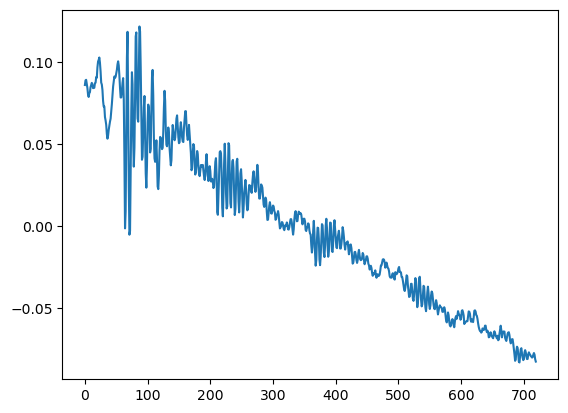

In [11]:
plt.plot(clickaudio[10,0,:]);

In [24]:
tstamp = get_timestamp_now()[0]
print(tstamp)

# Save all extracted audio as 'unscaled' and 'pknorm'.
for s, saudio in (('unscaled', clickaudio), ('pknorm', ceti.normalize_audio(clickaudio.copy(), remdc=False, peak_scale=1.0))):
    for chanidx, chanstr in enumerate(('left', 'right')):
        outfile = wavdir.parent / f'{eventtype}clicks.{chanstr}.{tstamp}.{s}.{saudio.shape[-1]}samples.wav'
        wavfile.write(outfile, resample_rate, saudio[:,chanidx,:].ravel())
        print(outfile)

# Save click dataframe. The `audidx` column matches dataframe rows to
# its sequence in the audio file.
csvout = wavdir.parent / f'{eventtype}clicks.{tstamp}.csv'
clicks.to_csv(csvout, index=False)
print(csvout)

/global/scratch/users/rsprouse/datasets/ceti/calfclicks.2023-12-08T151836.csv


In [23]:
codadf = pd.DataFrame({
    'text': clicks[~clicks['fauxda'].duplicated()]['fauxda'].astype(str),
    't1': clicks[~clicks['fauxda'].duplicated()].index * click_window,
    't2': clicks[~clicks['fauxda'].duplicated(keep='last')].index * click_window + click_window
})

clickdf = pd.DataFrame({
    'text': clicks['clicknum'].astype(str),
    't1': clicks.index * click_window,
    't2': clicks.index * click_window + click_window
})

outfile = wavdir.parent / f'{eventtype}clicks.{tstamp}.TextGrid'
clicktg = df2tg(
    [codadf, clickdf],
    tnames=['coda', 'clicknum'],
    lbl='text',
    fmt='0.4f',
    fill_gaps=None,
    outfile=outfile
)
print(outfile)

/global/scratch/users/rsprouse/datasets/ceti/calfclicks.2023-12-08T151836.TextGrid
